In [36]:
import torch
import torchvision.transforms as T 
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn 
from PIL import Image
import numpy as np
import os
from einops import rearrange

In [86]:
IMAGE_SIZE = 64
BATCH_SIZE = 2
NUM_WORKERS = 4

In [6]:
image_to_tensor = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Lambda(lambda t: (t*2)-1),
])

In [42]:
tensor_to_image = T.Compose([
    T.Lambda(lambda t: (t+1)/2),
    T.Lambda(lambda t: rearrange(t, 'c h w -> h w c')),
    T.Lambda(lambda t: t*255),
    T.Lambda(lambda t: t.numpy().astype(np.uint8)),
    T.ToPILImage(),
])

In [29]:
class MonetDataset(Dataset):
    def __init__(self):
        self.image_path = './datasets'
        self.image_list = os.listdir(self.image_path)

    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image_name = os.path.join(self.image_path, self.image_list[index])
        image = Image.open(image_name)
        return image_to_tensor(image)

In [79]:
# testing the dataloading pipeline
data = MonetDataset()
dataloader = DataLoader(data, batch_size=1)

image = iter(dataloader)

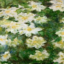

In [82]:
tensor_to_image(next(image)[0])

In [87]:
datasets = MonetDataset()
dataloader = DataLoader(datasets, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [85]:
def forward_diffusion(input_image):
    beta = torch.linspace(0.0001, 0.02, 1000)
    alpha = 1 - beta 
    alpha_hat = torch.cumprod(alpha, dim=-1)

    time_stamps = torch.randint(1, 1000, (BATCH_SIZE,))

    alpha_hat_t = alpha_hat.gather(-1, time_stamps).reshape(-1, 1, 1, 1)

    noise = torch.randn_like(input_image)

    noise_image = torch.sqrt(alpha_hat_t) * input_image + torch.sqrt(1 - alpha_hat_t) * noise

    return noise_image

In [88]:
images = iter(dataloader)

In [91]:
noise_images = forward_diffusion(next(images))

In [93]:
noise_images.shape

torch.Size([2, 3, 64, 64])

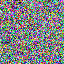

In [96]:
tensor_to_image(noise_images[0])